# Tier 1 EM1 Lab Curve Fitting

## Preliminaries
This analysis is done in the Python programming language using a Jupyter notebook interface. Python has hundreds of specialized packages for scientific applications, but we will restrict ourselves here to the core packages that are commonly used in data analysis. We will describe them as we use them, leaving a more comprehensive introduction to Python and its associated scientific programming ecosystem for later. You can find more documentation at the links below.
* [Python](https://docs.python.org/3/tutorial/index.html): the high-level computing language
* [Jupyter](https://jupyter-notebook.readthedocs.io/en/latest/): the notebook interface for Python programming and documentation
* [NumPy](https://docs.scipy.org/doc/numpy-1.15.0/user/index.html): a numerical computing package
* [matplotlib](https://matplotlib.org/users/index.html): a scientific visualization package
* [SciPy](https://docs.scipy.org/doc/scipy/reference/tutorial/index.html): an extension of the NumPy package that includes additional functionality for scientific applications
* [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Here-Cheatsheet#emphasis): the markup language used for formatting text cells in Jupyter—this is not technically part of Python, but is useful for documenting Python-based analysis in Jupyter notebooks

## Step 1: Import packages
We will need NumPy, the `pyplot` subpackage from matplotlib, and the `curve_fit` routine from SciPy, so we import these into the notebook in the following cell.

The first line in the cell is a comment, `# Import packages`, which we identify by beginning the line with the `#` character. Python ignores these lines, so we can use them to include brief comments in plain English that describe what the Python code does.

The first line of code in the cell tells Python to load the `numpy` package under the name `np`, which is a standard abbreviation that is more convenient for typing. Similarly, `matplotlib.pyplot` is commonly abbreviated as `plt`. Both `np` and `plt` include a variety of routines, as we will see below. The third line imports just the `curve_fit` routine from the `scipy.optimize` subpackage of SciPy, without assigning an abbreviated name to it. Similarly, the fourth line imports just the `chi2` routine from the `scipy.stats` subpackage of SciPy.

The last line, `%matplotlib inline`, is preceded by a `%` to signal that it is not a Python command but a system  command, known as a *magic command*. In this case the system is the Jupter notebook server, and `%matplotlib inline` tells it to show plots from Matplotlib in the notebook, or *inline*.

In [1]:
# Import packages
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Tell notebook server to show plots inline
%matplotlib inline

## Input data directly
For small data sets, you can input data directly into Python. However, all IOLab files contain too many points for hand entry.

In [2]:
a7 = np.array([0.63, 0.836, 0.953, 1.159, 1.365, 1.582, 1.783, 1.995, 2.195, 2.295])
a7_err = np.array([1.6e-3, 1.9e-3, 1.9e-3, 2.3e-3, 3.1e-3, 4.3e-3, 3.5e-3, 3.9e-3, 4e-3, 4.2e-3])
a8 = np.array([0, 0, 0, 0, 0.001, 0.053, 0.196, 0.377, 0.558, 0.65])
a8_err = np.array([0, 7.6e-5, 1.6e-15, 0, 3.4e-4, 1.4e-3, 2.1e-3, 2.4e-3, 0.0027, 3e-3])
hg = np.array([-0.011, -0.011, -0.011, -0.011, -0.01, 0.065, 0.266, 0.522, 0.776, 0.906])
hg_err = np.array([1.2e-4, 1.6e-4, 1.6e-4, 2.1e-4, 2e-4, 1.7e-4, 1.7e-4, 2.1e-4, 2.3e-4, 2.2e-4])

## Step 3: Plot the data
To plot the data for analysis, we turn to the routines contained in `matplotlib.pyplot`, which we imported earlier under the abbreviated name `plt`. All of the PyPlot routines are listed on its [help page](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html), which links to additional help on each routine.

1. Choose the independent and dependent variables to plot. The mass scale precision is 1 gm but the displacement uncertainty is much larger. This suggests we use the weight (or mass) as the independent variable.

2. Choose the functional relationship to show. Hooke's law is a linear relationship, so we will just plot the displacement directly as a function of mass (or weight). Later we will see how to demonstrate certain types of nonlinear relationships by *linearizing* the data.

3. Choose the plotting function. The following cell shows the displacement as a function of mass (or weight), with the displacement uncertainty represented by an error bar. The first line calls the `errorbar` routine from `plt`. The first two arguments of `errorbar` are required, and correspond to the $x$ and $y$ variables in the plot, respectively. The third argument, `yerr=y_err`, tells `errorbar` to show errobars that extend `err` above and below the data point along the $y$ axis. The fourth argument, `fmt='o'` causes the data points to be represented as circles (`o`). For more details on `errorbar`, see its [help page](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.errorbar.html). After the `errorbar` statement, the next three lines produce labels for the $x$ and $y$ axes, along with the title. The last line displays the plot.

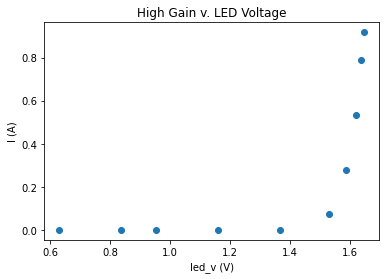

In [36]:
# plt.errorbar(x_dat, y_dat, yerr=y_err, fmt='o')
plt.scatter(led_v, I)
plt.xlabel('led_v (V)')
plt.ylabel('I (A)')
plt.title("High Gain v. LED Voltage")
plt.show() #using default size figure

## More preprocessing

In [3]:
# actual voltage across LED
led_v = a7-a8
# systematic G+/- error
hg_shift = -0.011
# current across 1 Ohm resistor=voltage
I = hg - hg_shift

x_dat = led_v
y_dat = I
y_err = hg_err

In [4]:
x_dat, y_dat, y_err

(array([0.63 , 0.836, 0.953, 1.159, 1.364, 1.529, 1.587, 1.618, 1.637,
        1.645]),
 array([0.   , 0.   , 0.   , 0.   , 0.001, 0.076, 0.277, 0.533, 0.787,
        0.917]),
 array([0.00012, 0.00016, 0.00016, 0.00021, 0.0002 , 0.00017, 0.00017,
        0.00021, 0.00023, 0.00022]))

## Step 4: Define the model function
In Intro Lab 4, we fit the data with a proportional model,

$$y = mx,$$

and a simple linear model,

$$y = mx+c,$$

where $x$ represents the weight, $y$ the displacement, and $m$ and $b$ represent *unknown fit parameters* that we will determine from the data.

In the cell below we use the Python statement `def` to define each of these model functions. The first line specifies  `model_prop`as the name of the function and indicates what arguments it expects. For consistency with the `curve_fit` routine, we reserve the first argument for the independent variable `x`, followed by the fit parameter `m`. The second line uses the Python statement `return` to specify the output of appropriate `model`, which in the first case is the output of the expression `m*x`. *It is important to note here that the* `return` *statment is indented.* Unlike many other programming languages, Python assigns significance to indentation. Here, it assumes that any indented text after the `def` statement is part of the function definition. The definition for `model_lin` follows the same methodology, with fit parameters `m` and `c`.

#### Tip: Express the model function in appropriate units
The default behavior of `curve_fit` is to stop adjusting any fit parameter that has been specified to an absolute numerical precision of 10<sup>-8</sup> or better. This will cause your fit to stop prematurely if you use units that make your optimal fit parameters numerically small, so you should typically use units for both your data and your fit parameters that yield numerical values much larger than 10<sup>-8</sup>.

In [7]:
# Define model functions  -- the independent variable has to be the first argument

#proportional model y=mx
def model_prop(x,m):
    return m*x

#linear model y=mx+c
def model_lin(x,m,c):
    return m*x + c

## Step 5: Choose initial parameter values for the model
After defining the model, it is generally good practice to compare the model to the data at a qualitative level before handing it off to the computer for a quantitative fit. Doing this will help you catch any mistakes in your model definition, develop an intuition for how the fit quality varies with the parameters, and choose initial values for the parameters that are reasonably close to optimal. The simple model in our example will converge regardless of the initial parameter choice, but in more complex models, having good values for the initial fit parameters is often essential to achieving a good fit.

If you inspect the raw data in the errorbar plot above for the proportional fit, you should see that the slope is close to 0.025 for an intercept of zero. You can also see this relationship in the tabular data. Consequently, we assign the initial parameter values `mInit = 0.025` and `bInit = 0` in the first two lines of code in the cell below. The remaining lines create a plot that shows how the model fits the data with these preliminary values for the fit parameters. 

First, we use the NumPy routine `linspace` to create `fModel`, an array with equally-spaced points ranging from 0 to 10. This allows us to extend the model curve to frequencies outside of the range of the original data. Also, for models that are not simply a straight line, it provides us with a way to control how smooth the model curve looks by adjusting the point density.

Next, we use `plot` from PyPlot to show the model curve evaluated at all points in `fModel` with the parameters `mInit` and `bInit`. The third argument, `'r-'`, tells `plot` to represent this as a red line. The next lines use `errorbar`, `xlabel`, `ylabel`, and `title` to add the data as an errorbar plot, label the axes, and add a title, just as before. We then use `xlim` and `ylim` to adjust the limits of the $x$ and $y$ axes, respectively, and `show` to display the final plot.

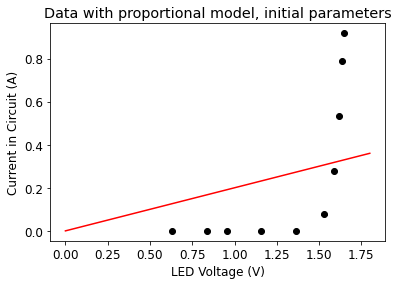

In [56]:
# Set initial parameters m0 and b0
mInit=0.2

# Define new frequency array, fModel, for displaying the model
fModel = np.linspace(0,1.8)

# Make the plot
# Recall the order of the arguments in the model definition, model(x,m,b):
plt.plot(fModel,model_prop(fModel,mInit),'r-')
# plt.scatter(x_dat, y_dat)
plt.errorbar(x_dat, y_dat, yerr=y_err, capsize = 3, capthick = 1, fmt='ko')
plt.title('Data with proportional model, initial parameters')
plt.xlabel('LED Voltage (V)')
plt.ylabel('Current in Circuit (A)')
# plt.xlim(0,1.8)
# plt.ylim(0,1)
plt.show()

## Step 6: Fit the model to the data
Now we have everything we need to use `curve_fit` to find the parameter values that provide the best fit of the model to the data. As described in the [help](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), `curve_fit` has three required arguments: the model, the data $x$ values, and the data $y$ values, in that order. We also include three additional optional arguments. The expression `p0=[mInit,bInit]` specifies the initial guess for the parameters, expressed as a single array in the order of their appearance in the model, `model_prop` in the initial fit with `c=0` and `model_lin` for the improved fit. 

We are using unweighted fits in Intro Labs 4 & 5 and the code below implements it. 

The first output of `curve_fit` is an array of the optimal parameter values, listed in the order of their appearance in the model. We can write it in matrix form. Here we will illustrate with the more general improved fit case, with `prop_opt`being the output of `model_lin`:

$$ {\mathbf{p}} = \begin{bmatrix}{p}_0\\ {p}_1\end{bmatrix} = \begin{bmatrix}{m} \\ {b}\end{bmatrix},$$

where ${m}$ indicates the optimal value for the parameter $m$.

The second output, `pCov`, is a two-dimensional array that corresponds to the parameter *covariance matrix*, which provides an estimate of the parameter uncertainty and correlation. As described in Chapter 7 of Hughes and Hase, the diagonal elements of `pCov` correspond to the *variance* of the associated parameters. In our example, the covariance matrix is

$$ \mathbf{C} = \begin{bmatrix}C_{00} & C_{01}\\ C_{10} & C_{11}\end{bmatrix} = \begin{bmatrix}\alpha_m^2 & \rho_{mc}\alpha_m\alpha_c\\ \rho_{mb}\alpha_m\alpha_c & \alpha_c^2\end{bmatrix}, $$

where $\alpha_m$ is the standard error in the slope estimate ${m}$, $\alpha_c$ is the standard error in the intercept estimate ${c}$, and $\rho_{mc}$ is the *correlation coefficient* between ${m}$ and ${c}$, discussed in Sec. 7.3 of Hughes and Hase.

WE ONLY USE THE DIAGONAL ELEMENTS IN PHYSICS 5BL.

For the proportional model `model_prop`,  ${\mathbf{p}}={m}$ and $\mathbf{C}= {\alpha_m^2}$

### Weighted fits
When we get to Intro Lab 6, we'll use weighted fits so you'll add another parameter, `sigma=y_err`, which specifies the uncertainty in the data $y$ values and `absolute_sigma=True`, which indicates that these uncertainties are known independently, as is usually the case in physics. The fit then becomes:  
`lin_opt, lin_cov = opt.curve_fit(model_lin, x_dat, y_dat, p0=[mInit,bInit], sigma=y_err, absolute_sigma=True))`

In [15]:
# Fit the initial y=ax model to the data and display results
prop_opt, prop_cov = opt.curve_fit(model_prop, x_dat, y_dat, p0=[mInit])

# Extracting the standard errors in the fit parameters, from the covariance matrix diagonal
prop_err = np.sqrt(np.diag(prop_cov))

# Displaying   ("\u00B1" is the plus/minus symbol)
# We're using string formatting with the "%" to limit the # of digits... just look it up

print("a = %5.3f \u00b1 %5.3f A/V" % (prop_opt[0], prop_err[0]))

a = 0.233 ± 0.072 A/V


## Step 7: Assess the fit
The fit parameters and uncertainties returned by `curve_fit` are only as good as the fit itself, so it is *essential* that you evaluate the fit quality before relying on them. Hughes and Hase describe several ways to do this, and we will show below how to use Python for the most common ones.

### Assessing the fit: visual inspection
We already compared the model to the data for the initial parameters, so we can use the same routines to do the same comparison with the optimal parameters.

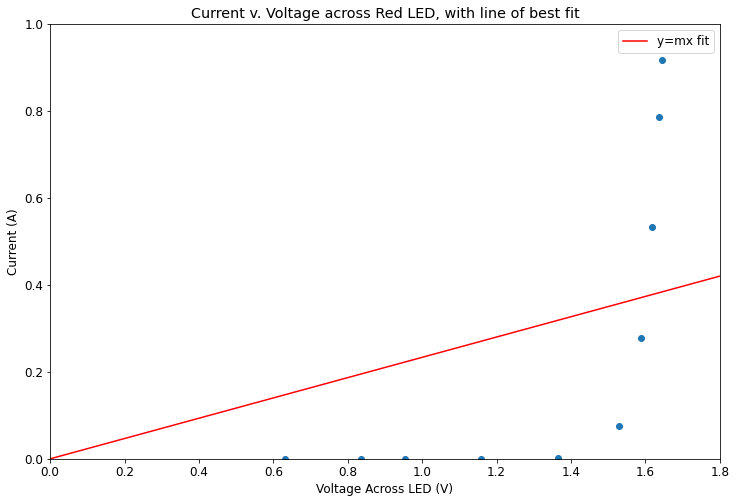

In [16]:
# Plot data with best-fit for the model y=ax
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0,1.8),model_prop(np.linspace(0,1.8), prop_opt[0]),'r-', label="y=mx fit")
plt.scatter(led_v, I)
plt.title('Data with linear model, initial parameters')
plt.xlabel('Voltage Across LED (V)')
plt.ylabel('Current (A)')
plt.title("Current v. Voltage across Red LED, with line of best fit")
plt.xlim(0,1.8)
plt.ylim(0,1)
plt.legend()
# plt.text(.05,.14, "Fit line equation: y=%5.4fx" %(prop_opt[0]))
# plt.text(.05,.12, "m = %5.4f \u00b1 %5.4f m/N" % (prop_opt[0], prop_err[0]))
# plt.text(.05,.10, "χ2 = %5.4f" % (chi2_prop))

# plt.text(.5,.01, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[0], y_err[0]))
# plt.text(.8,.03, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[1], y_err[1]))
# plt.text(1.25,.06, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[2], y_err[2]))
# plt.text(1.6,.09, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[3], y_err[3]))
# plt.text(1.9,.12, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[4], y_err[4]))
# plt.text(1.8,.17, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[5], y_err[5]))

# plt.show()
plt.savefig('fig1.png')

### Assessing the fit: plot the residuals
We can check for statistical consistency by confirming that the residuals do not show any systematic pattern. We consider the initial proportional fit function `y=mx`.


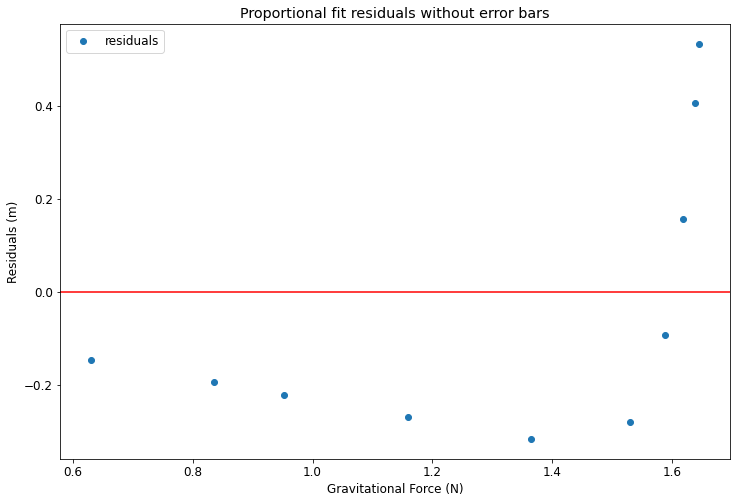

In [17]:
# Predicted y values from the fit to model y=ax
y_prop = model_prop(x_dat, prop_opt[0])

# Proportional model residuals defined
r_prop = y_dat - y_prop

# Sets figure size etc. by starting with plt.figure
fig2=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

# Residuals without error bars
plt.errorbar(x_dat, r_prop, yerr=None, fmt='o', label='residuals')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Proportional fit residuals without error bars")
plt.xlabel("Gravitational Force (N)")
plt.ylabel("Residuals (m)")
plt.legend()
# plt.show()
plt.savefig('fig2.png')

### Assessing the fit: compute the $\chi^2$ statistic
Beyond visual inspection, also known perjoratively as *$\chi$-by-eye*, we can assess the fit more quantitatively by computing the $\chi^2$ statistic. We first consider the proportional case, `y=mx`, 

$$ \chi^2 = \sum_{i=1}^N\frac{[y_i - y (x_i)]^2}{\alpha_{i}^2},$$

where ${{m}}$ is the first (only) element in the array of best-fit parameters ${\textbf{p}}$, $y (x_i)$ is the model function with independent variable $x$ and parameter array ${\textbf{p}}$, and the sum is over all $N$ data points $(x_i, y_i)$ and error $\alpha_i$ in the $y$ variable.

We compute this statistic for our example in the cell below, following three steps. First, we compute the fit *residuals*, given by the set $\ y_i - y (x_i) \,$ $i = 0, 1, ... N$, and assign it to the array `res`. Next, we normalize each residual value to its estimated uncertainty, and assign it to `norm_res`. Finally, we compute the $\chi^2$ statistic by summing over the squares of each normalized residual.

$\chi^2$ is more extensively discussed in Intro Labs 5 and 6

In [18]:
# Calculating the chisq (*not reduced*)
def chisq(predicted, observed, errors):
    res = observed-predicted
    print(res, errors)
    norm_res = res / errors 
    return np.sum(norm_res**2)

chi2_prop = chisq(y_prop, y_dat, y_err)

print('χ2 (for proportional model y=mx) ={0:.3f}'.format (chi2_prop))

[-0.14701741 -0.19508977 -0.22239301 -0.27046536 -0.31730436 -0.28080892
 -0.09334386  0.15542195  0.40498809  0.5331212 ] [0.00012 0.00016 0.00016 0.00021 0.0002  0.00017 0.00017 0.00021 0.00023
 0.00022]
χ2 (for proportional model y=mx) =21645996.220


## Repeat process for the linear model

In [19]:
# The order of the parameter array elements p0, lin_opt, and lin_cov
# are determined by their order [m,b] in the model definition, model_lin(x,m,b):
# we are using an unweighted fit

# Set initial parameters mInit and bInit
mInit=0.2
cInit=-0.05

#fit the unweighted model y=mx+b
lin_opt, lin_cov = opt.curve_fit(model_lin, x_dat, y_dat, p0=[mInit,cInit])

In [20]:
# Predicted values
y_lin = model_lin(x_dat, lin_opt[0], lin_opt[1])

#error in the fit variables
lin_err = np.sqrt(np.diag(lin_cov))  

print('m = {0:6.4f} ± {1:5.4f} A/V'.format(lin_opt[0], lin_err[0]))
print(f"c = {lin_opt[1]:.4f} ±  {lin_err[1]:.4f} A")


m = 0.6726 ± 0.2378 A/V
c = -0.6125 ±  0.3197 A


### Assessing the fit: compute the $\chi^2$ statistic
Beyond visual inspection, also known perjoratively as *$\chi$-by-eye*, we can assess the fit more quantitatively by computing the $\chi^2$ statistic. 

For the improved linear fit `y=mx+b` model:

$$ \chi^2 = \sum_{i=1}^N\frac{[y_i - y (x_i)]^2}{\alpha_{i}^2},$$

where ${\hat{m}},{\hat{c}}$ are the elements in the array of best-fit parameters $\hat{\textbf{p}}$, $y (x_i)$ is the model function with independent variable $x$ and parameter array $\hat{\textbf{p}}$, and the sum is over all $N$ data points $(x_i, y_i)$ and error $\delta y_{i}$ in the $y$ variable.

We compute this statistic for our example in the cell below, following three steps. First, we compute the fit *residuals*, given by the set $\ y_i - y (x_i:{\hat{m},{\hat{b}})} \,$ $i = 0, 1, ... N$, and assign it to the array `res`. Next, we normalize each residual value to its estimated uncertainty, and assign it to `norm_res`. Finally, we compute the $\chi^2$ statistic by summing over the squares of each normalized residual.

$\chi^2$ is more extensively discussed in Intro Labs 5 and 6

In [21]:
#chi squared for linear case
chi2_lin = chisq(y_lin, y_dat, y_err)

print('χ2 =', chi2_lin) #unformatted, as an example


[ 0.18874923  0.05018369 -0.02851617 -0.16708171 -0.30397461 -0.33996158
 -0.17797518  0.05717272  0.2983924   0.42301122] [0.00012 0.00016 0.00016 0.00021 0.0002  0.00017 0.00017 0.00021 0.00023
 0.00022]
χ2 = 16096681.074505696


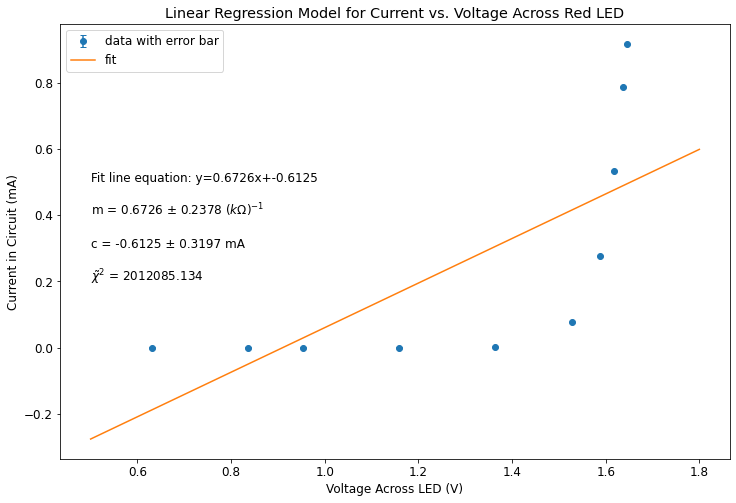

In [24]:
# Best-fit plot with error bars, parameters, chisq

# Sets figure size etc.
fig1 = plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

# Data with error bars
plt.errorbar(x_dat, y_dat, y_err, fmt='o', capsize=3,
             capthick=1, label="data with error bar")

# Best linear fit
# could also use: plt.plot(np.linspace(0,10), model_lin(np.linspace(0,10), lin_opt[0], lin_opt[1]), label='fit')
plt.errorbar(np.linspace(0.5, 1.8), model_lin(
    np.linspace(0.5, 1.8), lin_opt[0], lin_opt[1]), label='fit')

# Axes label and title
plt.title("Linear Regression Model for Current vs. Voltage Across Red LED")
plt.xlabel("Voltage Across LED (V)")
plt.ylabel("Current in Circuit (mA)")

# Best fit parameters, uncertainties, and chisq
plt.text(0.5, .4, "m = %5.4f \u00b1 %5.4f $(k\\Omega)^{-1}$" % (lin_opt[0], lin_err[0]))
plt.text(0.5, .3, "c = %5.4f \u00b1 %5.4f mA" % (lin_opt[1], lin_err[1]))
plt.text(0.5, .2, "$\\tilde{\\chi}^{2}$ = %5.3f" % (chi2_lin / 8)) # reduced chi-sq

plt.text(0.5, .5, "Fit line equation: y=%5.4fx+%5.4f" %
         (lin_opt[0], lin_opt[1]))

# plt.text(.5, .01, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[0], y_err[0]))
# plt.text(.8, .03, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[1], y_err[1]))
# plt.text(1.25, .06, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[2], y_err[2]))
# plt.text(1.6, .09, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[3], y_err[3]))
# plt.text(1.9, .12, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[4], y_err[4]))
# plt.text(1.8, .17, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[5], y_err[5]))

plt.legend()
# plt.show()
plt.savefig('fig3.png')

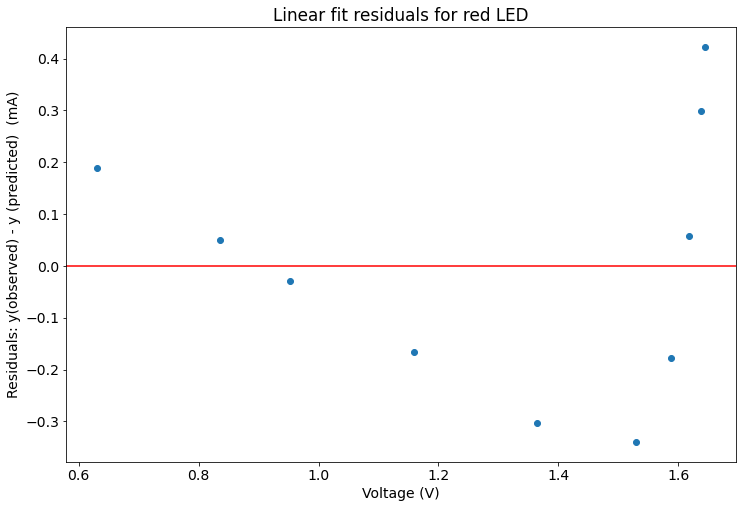

In [23]:
# Residuals plot

# Residuals
r_lin = y_dat- y_lin

# Sets figure size etc.
fig2=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '14'})

# Residuals
plt.errorbar(x_dat, r_lin, fmt='o')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Linear fit residuals for red LED")
plt.xlabel("Voltage (V)")
plt.ylabel("Residuals: y(observed) - y (predicted)  (mA)")
# plt.show()
plt.savefig('fig4.png')